# **Exercise 2: Predict Retrofit Impact**

## Overview

In this exercise, we use predictive analytics to assess the impact of retrofit actions. Leveraging insights from Exercise 1, we will use [Energy Performance of Buildings Data](https://epc.opendatacommunities.org/domestic/search) to answer questions such as:
- What is the expected reduction in energy consumption when upgrading wall insulation or HVAC efficiency?
- What are the expected cost savings by improving lighting efficiency?

## Set up

Load the required Python libraries and the data set. The data set contains information from 5000 buildings located in the London borough of Islington and is stored ```...\data raw\epc-certificates-Islington```; file ```certificates.csv``` contains the data and ```columns.csv``` explains the colunm headers. To load the data, update the ```path``` variable to the local folder location. 

For simplicity, columns with ```NaN``` values are dropped. An auxiliary function that estimates predictive accuracy, namely, mean squared error (MSE), root mean squared error (RMSE), and mean absolute error (MAE), is provided.

                                             LMK_KEY          ADDRESS1  \
0  05a4e13c8f8892b40f457e58195271839c253e738b2a4a...            Flat A   
1  07c0c456133427557a94e545821381d14767982acbf6cb...           Flat 17   
2  09ff1f899a2a4bfa4b183664b5d95962f6f636beba7616...           Flat 13   
3  104aed0a570454905c714411fff45406314dbb0cdcbf92...  144a Hanley Road   
4  117e6ac108ca5cb9de1ac1c4f5c82f526f8a6f7be28bf9...           Flat 16   

                  ADDRESS2            ADDRESS3 POSTCODE  \
0           32 Hanley Road                 NaN   N4 3DR   
1  Park Gate House 250-252  Seven Sisters Road   N4 2HU   
2  Park Gate House 250-252  Seven Sisters Road   N4 2HU   
3                      NaN                 NaN   N4 3DW   
4  Park Gate House 250-252  Seven Sisters Road   N4 2HU   

   BUILDING_REFERENCE_NUMBER CURRENT_ENERGY_RATING POTENTIAL_ENERGY_RATING  \
0                10008499045                     D                       C   
1                10003804896                

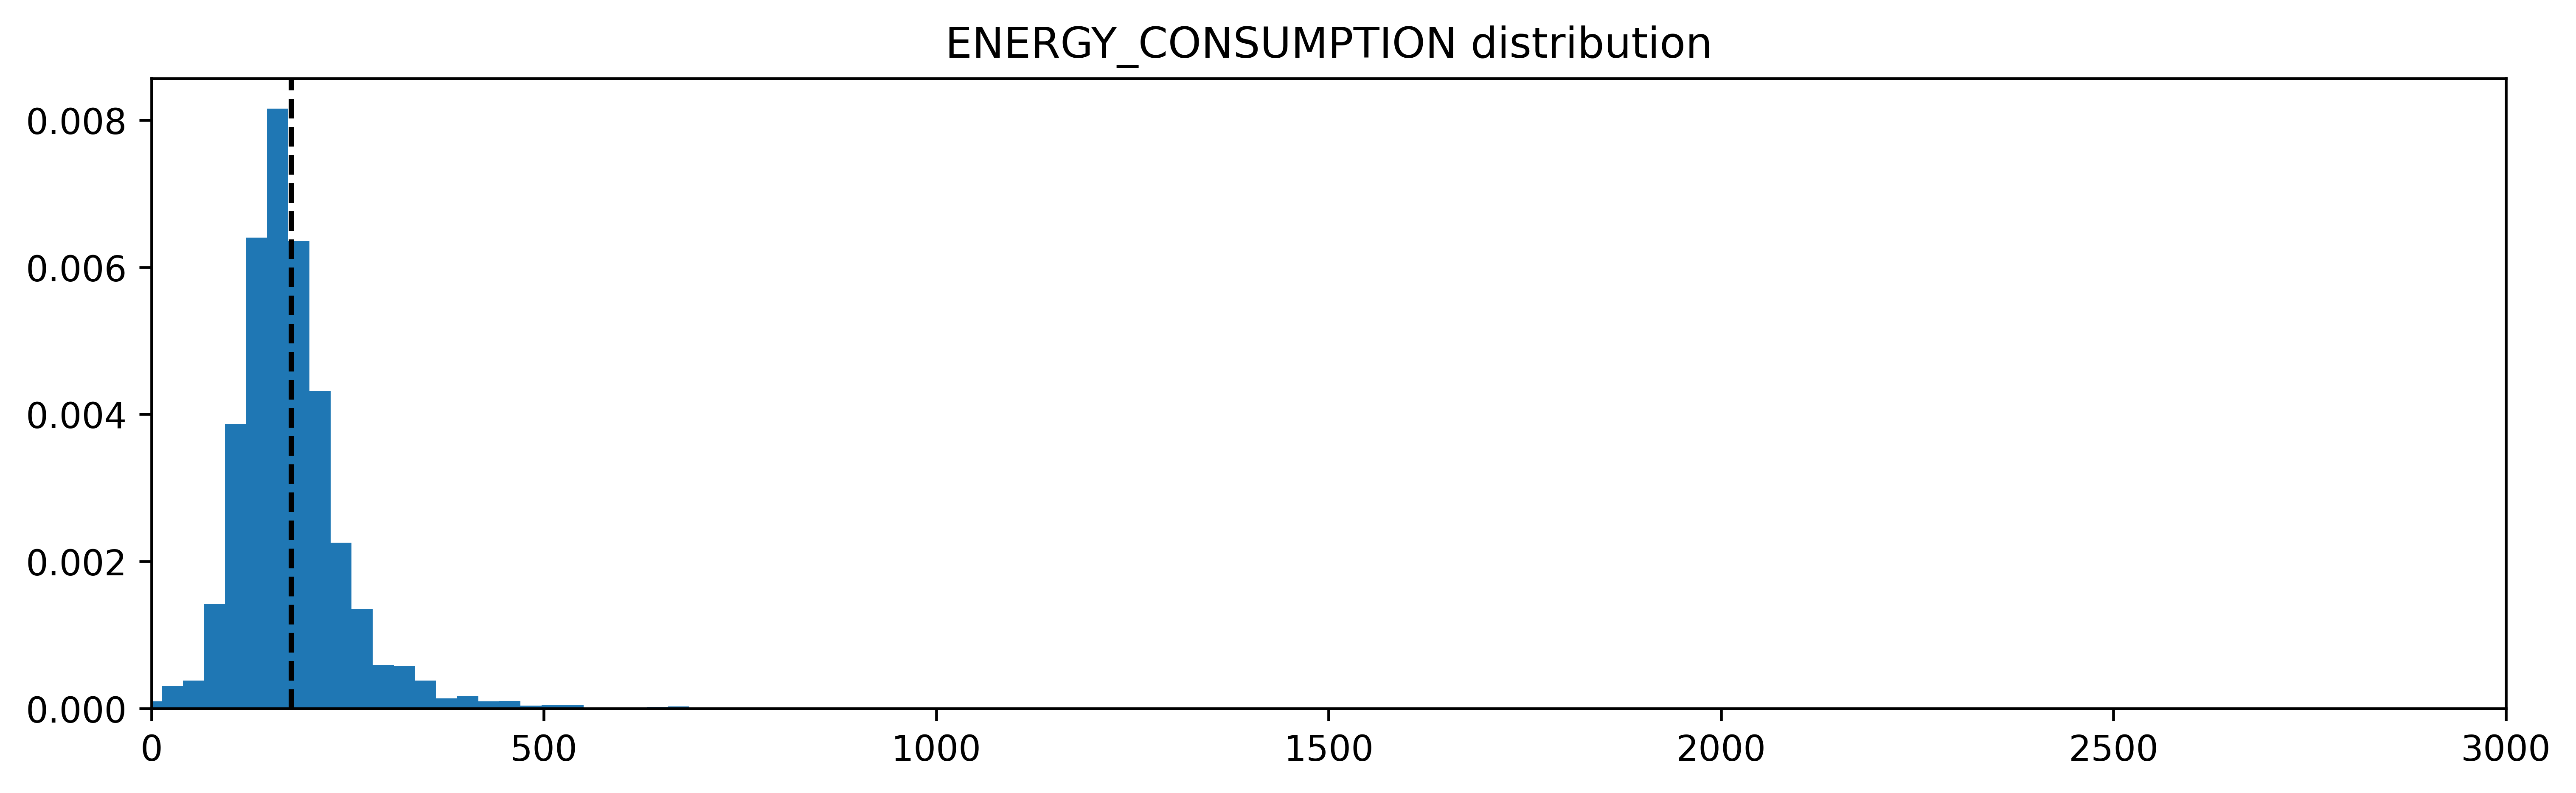

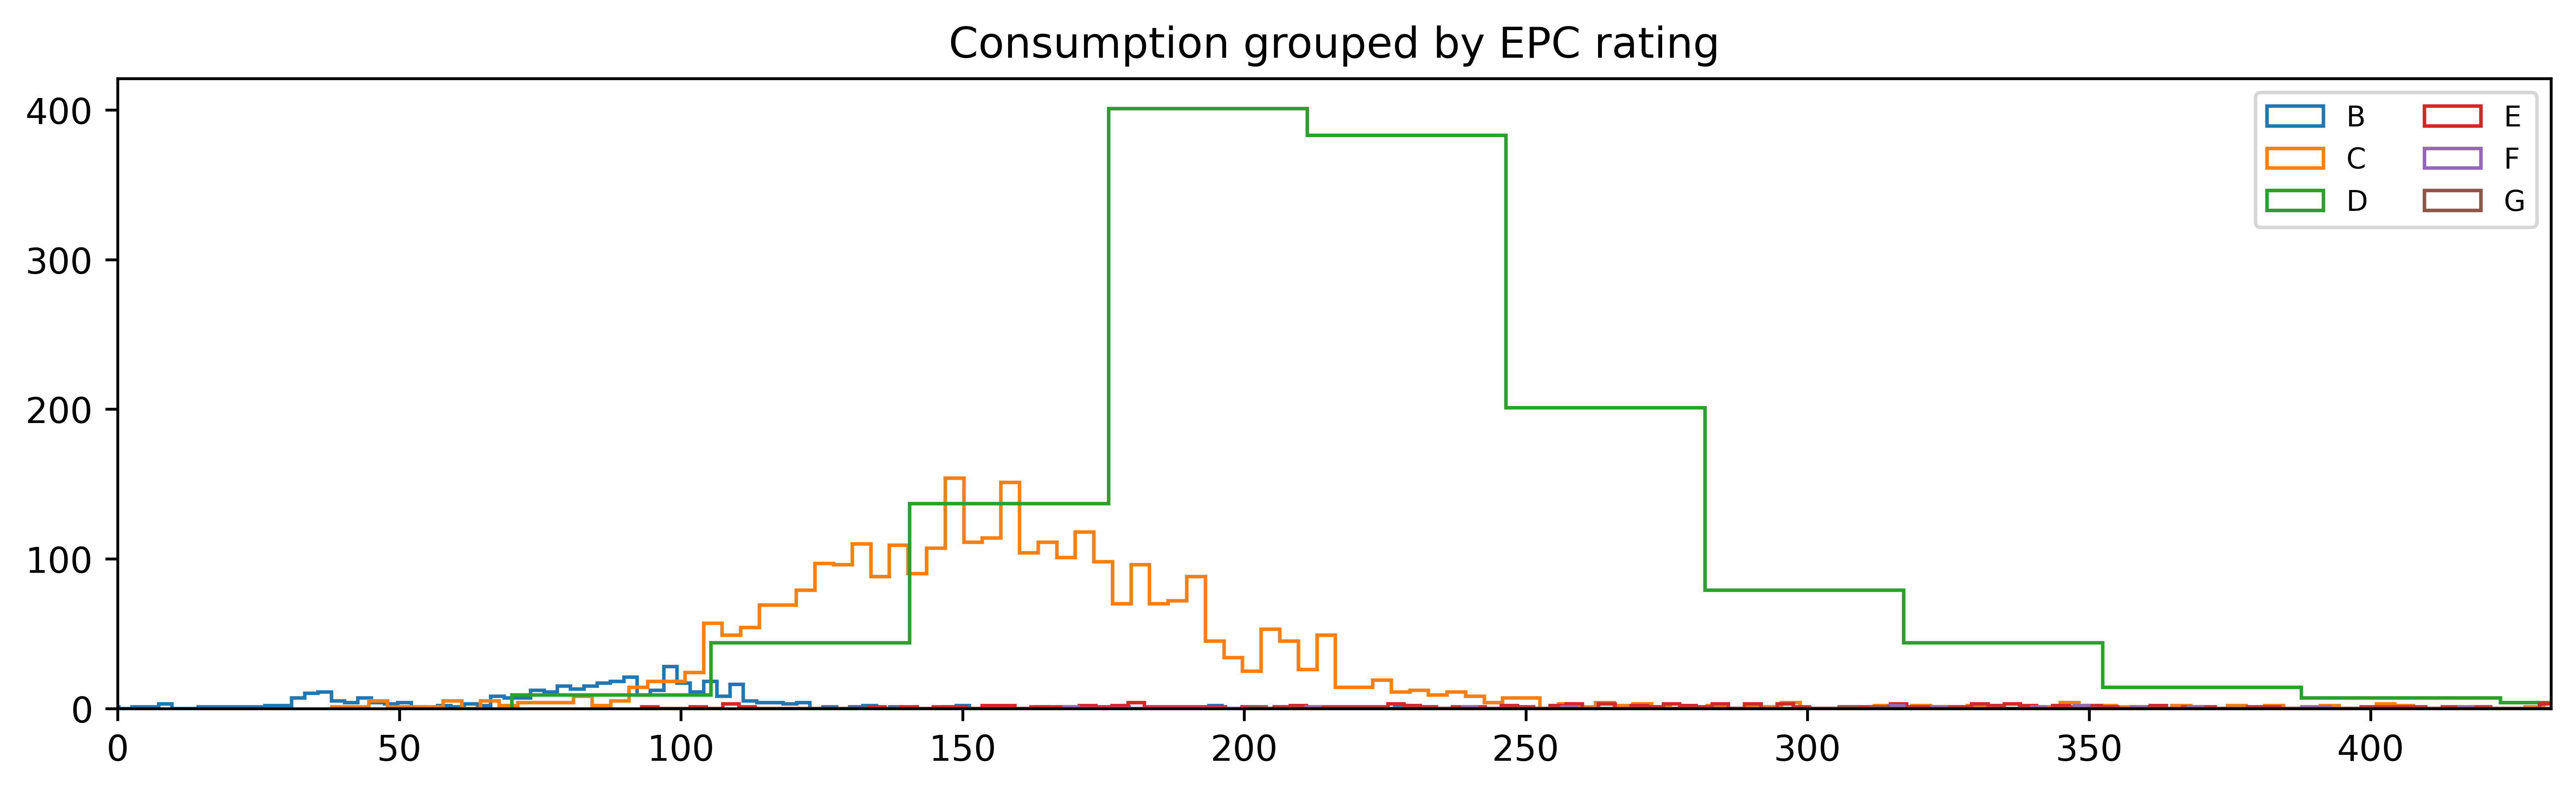

C:\Users\ucbva19\AppData\Local\Temp\ipykernel_2784\161546348.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cats, showfliers=False)


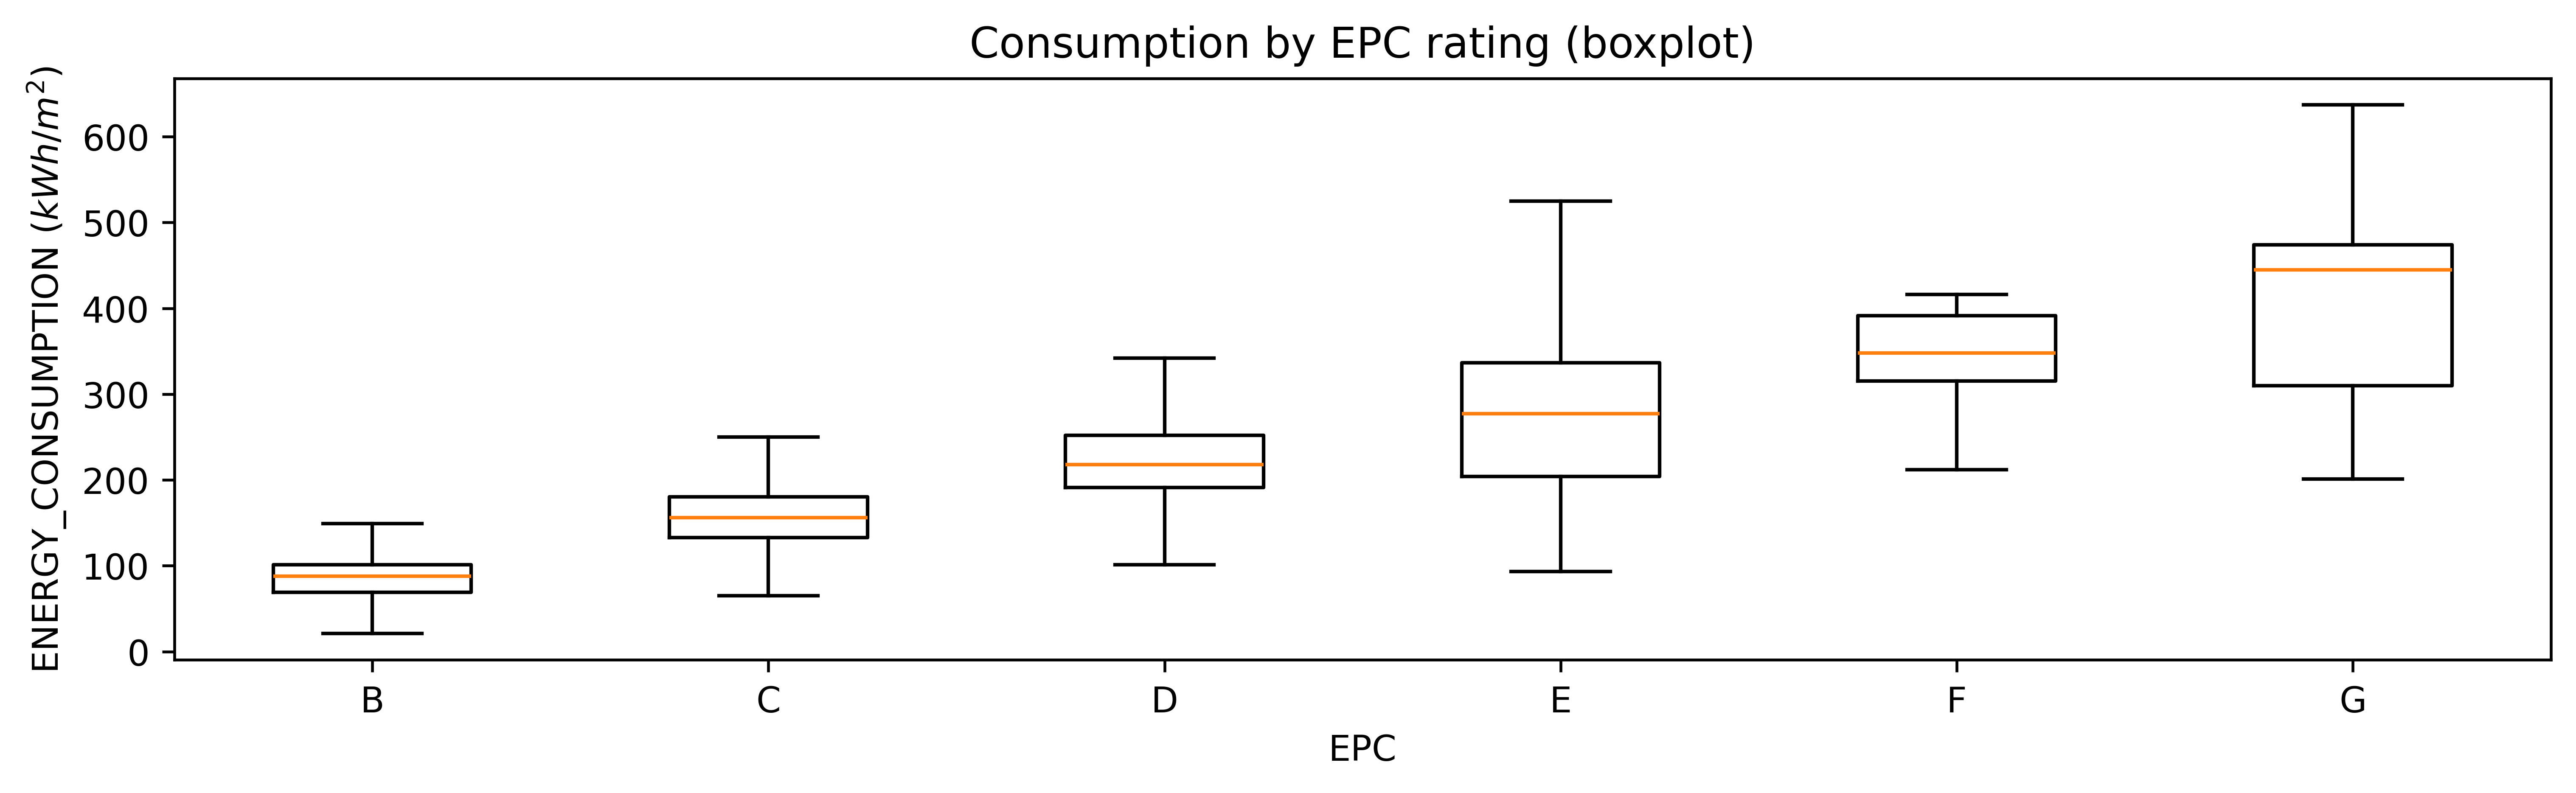

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def accuracy_metrics(actual, predictions):
    ''' Estimate predictive accuracy metrics '''
    actual_copy = actual.copy().reshape(-1,1)
    predictions_copy = predictions.copy().reshape(-1,1)
    
    error = actual_copy - predictions_copy    
    assert(error.shape[0] == len(actual_copy))
    if error.ndim > 1:        
        assert(error.shape[1] == 1)

    mse = np.square(error).mean()
    rmse = np.sqrt( mse )
    mae = np.abs(error).mean()
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    return rmse, mae

# default settings for plots
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (10,3)

path = 'C:\\Users\\ucbva19\\Git projects\\energy_analytics_built_env\\data raw\\epc-certificates-Islington'
df = pd.read_csv(f"{path}\\certificates.csv")  # change path

print(df.head())
print(df.isna().sum())

# drop columns with NaNs
df = df.dropna(axis=1)

assert(df.isna().sum().sum() == 0)


# Plot distribution
plt.figure()
plt.hist(df["ENERGY_CONSUMPTION_CURRENT"], bins=200, density=True)
plt.axvline(df["ENERGY_CONSUMPTION_CURRENT"].mean(), linestyle="--", color = 'black')
plt.xlim(0, 3000)
plt.title("ENERGY_CONSUMPTION distribution")
plt.show()

# EPC rating counts
plt.figure()
for k, g in df.groupby("CURRENT_ENERGY_RATING"):
    plt.hist(g["ENERGY_CONSUMPTION_CURRENT"], bins=150, histtype="step", label=str(k))
plt.xlim(0, df["ENERGY_CONSUMPTION_CURRENT"].quantile(0.99))
plt.title("Consumption grouped by EPC rating")
plt.legend(ncol=2, fontsize=8)
plt.show()

# Boxplot by EPC
plt.figure()
cats = sorted(df["CURRENT_ENERGY_RATING"].dropna().unique())
data = [df.loc[df["CURRENT_ENERGY_RATING"] == c, "ENERGY_CONSUMPTION_CURRENT"].values for c in cats]
plt.boxplot(data, labels=cats, showfliers=False)
plt.title("Consumption by EPC rating (boxplot)")
plt.xlabel("EPC")
plt.ylabel("ENERGY_CONSUMPTION $(kWh/m^2)$")
plt.show()

## Evaluate retrofit actions

The aim is to assess the impact of retrofit actions on variables energy consumption and costs. We consider the following target variables: ```ENERGY_CONSUMPTION_CURRENT```, ```HEATING_COST_CURRENT```, ```LIGHTING_COST_CURRENT```. We consider retrofit actions that improve energy efficiency by changing the values of features like ```['WALLS_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 'LIGHTING_ENERGY_EFF', 'HOT_WATER_ENERGY_EFF']```. The full process is described as follows:
- **Fit regression**: select a target variable and fit a predictive machine learning (ML) model.
- **Predict counterfactuals**: we predict what the target variable would have been under a retrofit action. For instance, to assess expected reductions when improving envelope insulation, we can change the value of ```WALLS_ENERGY_EFF``` from ```Very Poor```\ ```Poor``` to ```Very Good```.
- **Evaluation**: evaluate the difference between counterfactual and current true value and how it varies across building types.

### Solution example

In this example, we examine the impact of retrofit actions on ```ENERGY_CONSUMPTION_CURRENT```, by implementing the following steps:
- We compare two predictive models, namely ```LinearRegression``` and ```ExtraTreesRegressor```, using a training/test split.
- We select the best model and re-train using the full data set.
- We find buildings with low efficiencies, change the respective values, and assess potetial savings.

The following code snippet trains and compares the predictive ML models.

LR model
MSE: 2123.8824588739844
RMSE: 46.085599256969466
MAE: 25.20785978026504
ET model
MSE: 717.3338812210102
RMSE: 26.783089463708443
MAE: 13.316182020202021


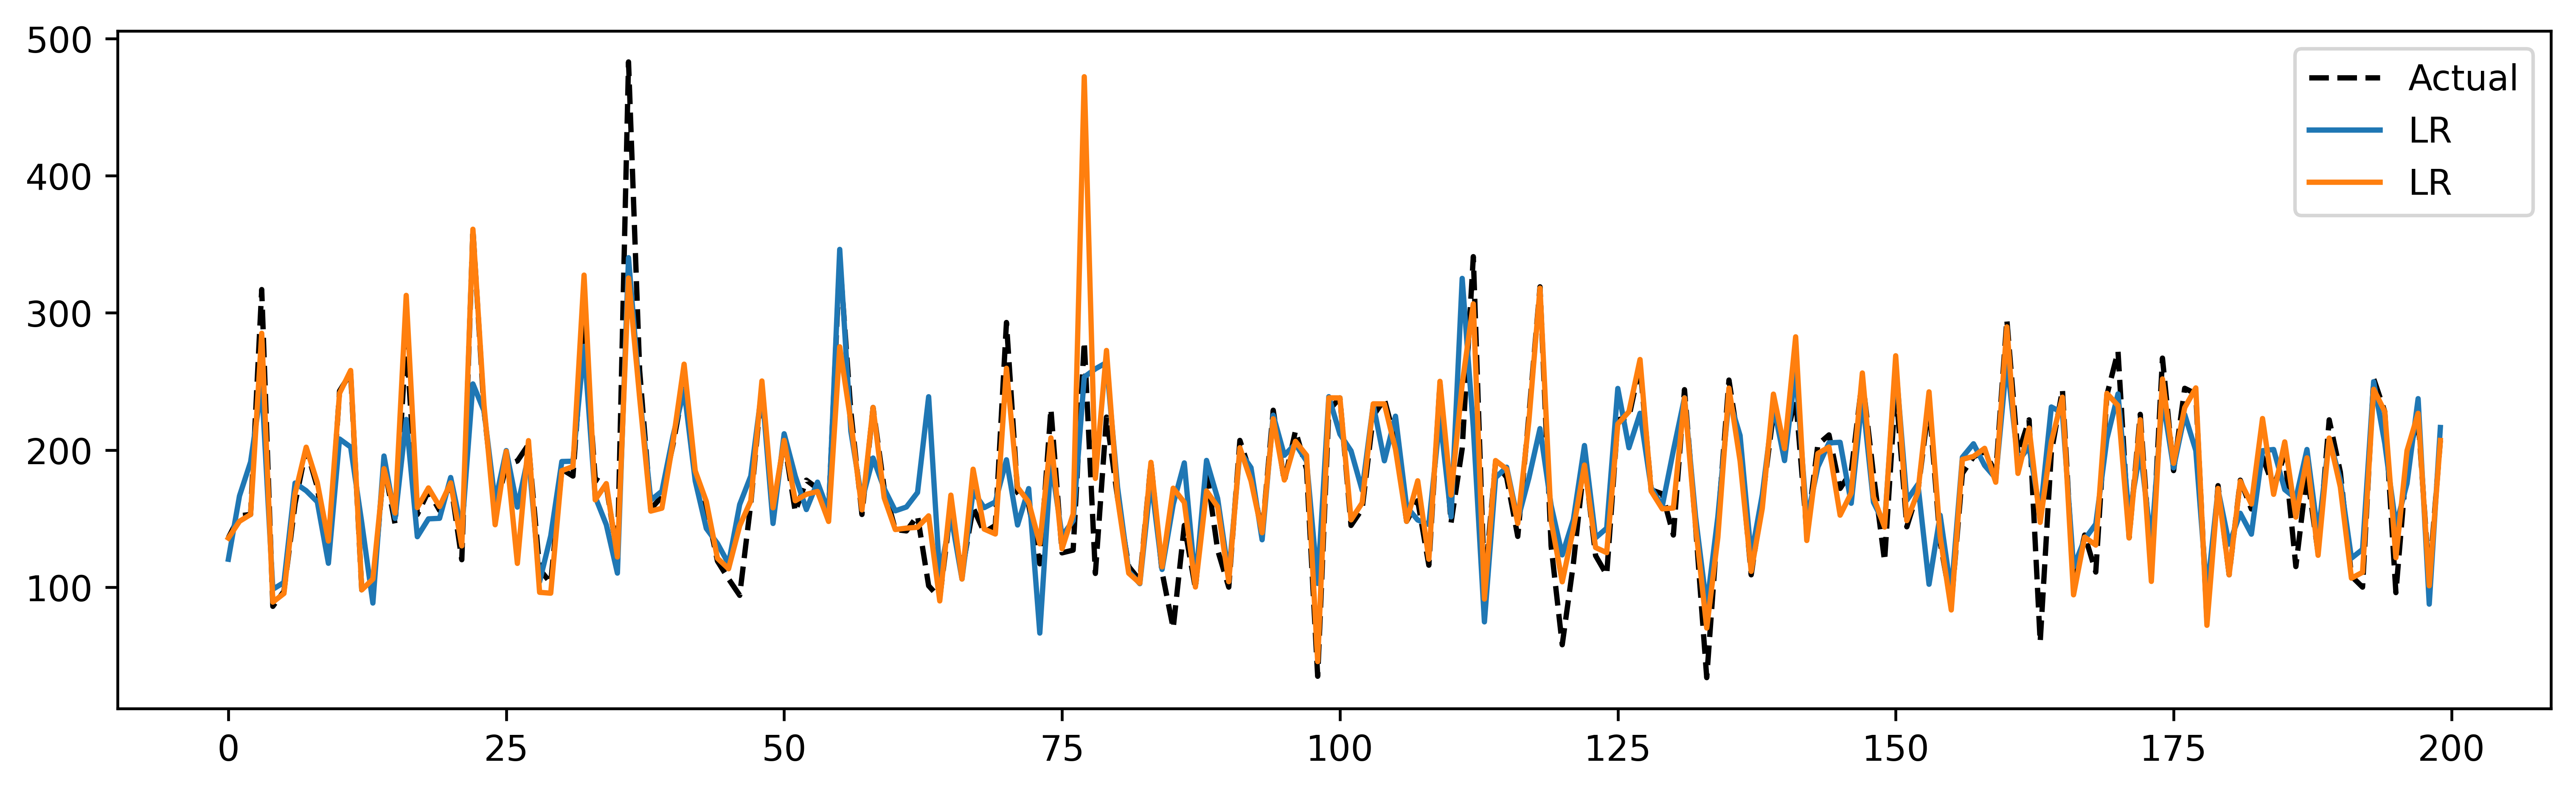

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('ord', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [4]:
#%% Step 1: Pre-process and fit regression model

# Load libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

target_variable = 'ENERGY_CONSUMPTION_CURRENT'

numerical_features = ['CURRENT_ENERGY_EFFICIENCY', 'TOTAL_FLOOR_AREA']
ordinal_features = ['WALLS_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 'LIGHTING_ENERGY_EFF', 'HOT_WATER_ENERGY_EFF']
categorical_features = ['PROPERTY_TYPE', 'BUILT_FORM']

Y = df[target_variable]
X = df[numerical_features + ordinal_features + categorical_features]

# Training/ test split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.33, random_state=42)

# Preprocessing
categories_list = [['Bungalow', 'Flat', 'House', 'Maisonette'], 
                  ['Not Recorded', 'Detached', 'Enclosed End-Terrace', 'Enclosed Mid-Terrace','End-Terrace', 'Mid-Terrace', 'Semi-Detached']]

ord_list =   [['Very Poor', 'Poor', 'Average', 'Good', 'Very Good'], 
              ['Very Poor', 'Poor', 'Average', 'Good', 'Very Good'],
              ['Very Poor', 'Poor', 'Average', 'Good', 'Very Good'], 
              ['Very Poor', 'Poor', 'Average', 'Good', 'Very Good']]

# create preprocessor that implements one-hot and ordinal encoding
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
                  ("ord", OrdinalEncoder(categories = ord_list), ordinal_features),
                  ("num", "passthrough", numerical_features),])


# LR Model pipeline
lr_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", LinearRegression()),
    ])

lr_model.fit(train_X, train_Y)
y_lr_pred = lr_model.predict(test_X)

# ExtraTree Model pipeline
et_model = Pipeline(steps=[("preprocess", preprocessor), ("regressor", ExtraTreesRegressor()),])
et_model.fit(train_X, train_Y)
y_et_pred = et_model.predict(test_X)

# evaluate accuracy 
print('LR model')
lr_rmse, _ = accuracy_metrics(test_Y.values, y_lr_pred)

print('ET model')
et_rmse, _ = accuracy_metrics(test_Y.values, y_et_pred)

plt.plot(test_Y.values[:200], '--', label = 'Actual', color = 'black')
plt.plot(y_lr_pred[:200], label = 'LR')
plt.plot(y_et_pred[:200], label = 'LR')
plt.legend()
plt.show()

# Re-train the best model using all the available data
et_model = Pipeline(steps=[("preprocess", preprocessor), ("regressor", ExtraTreesRegressor()),])
et_model.fit(X, Y)

The following code snippet implements retrofit actions and plots aggregate results.

Expected reduction in Energy Consumption: 28.84063067881986


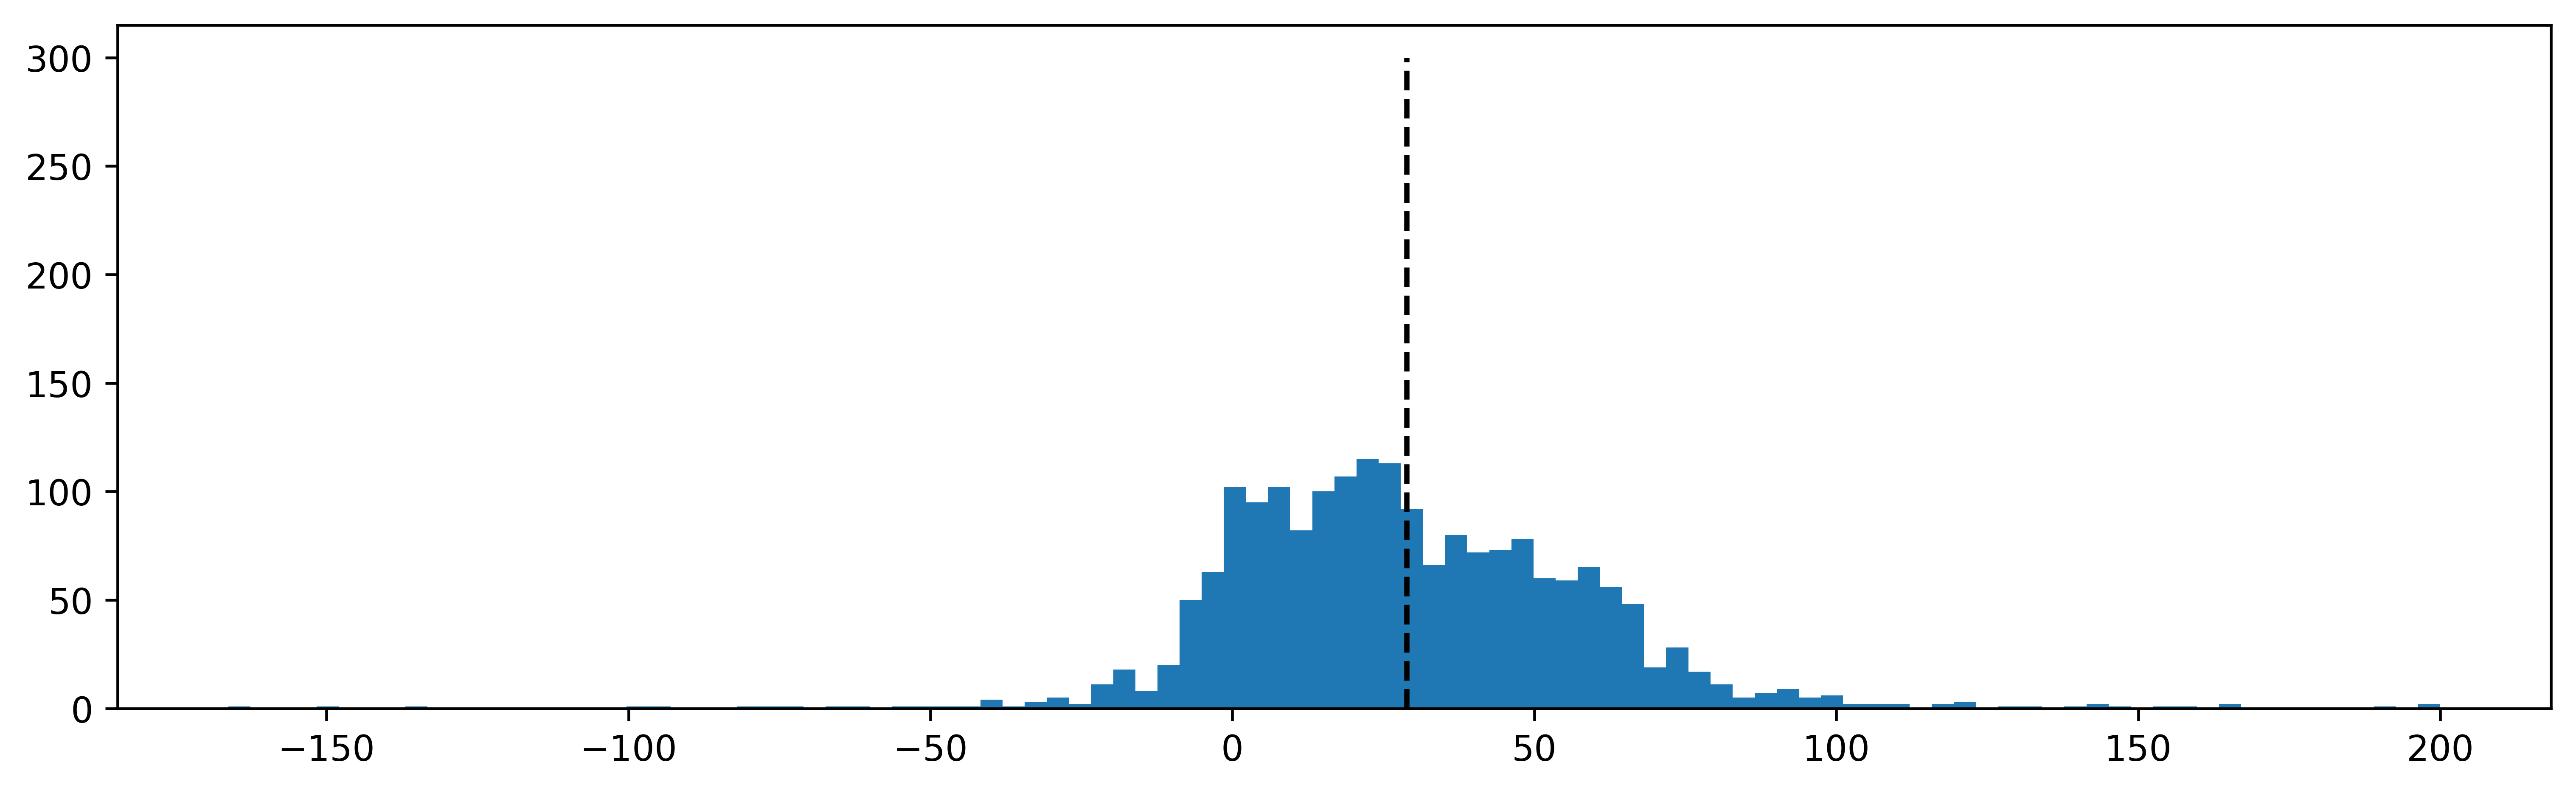

In [19]:
# ['WALLS_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 'LIGHTING_ENERGY_EFF', 'HOT_WATER_ENERGY_EFF']
target_action = ['WALLS_ENERGY_EFF']
current_efficiency_target = 'Poor'
potential_efficiency_target = 'Very Good'

# find buildings with current_efficiency_target
mask = X[target_action].values == current_efficiency_target

# select only relevant buildings
pre_retrofit_X = X.iloc[mask]

# change efficiency from current_efficiency_target to potential_efficiency_target
retrofit_X = pre_retrofit_X.copy()
retrofit_X[target_action] = potential_efficiency_target

# Predict counterfactual
counterfactual_Y = et_model.predict(retrofit_X)

# Estimate energy savings
delta_energy_predicted = Y.iloc[mask] - counterfactual_Y

print(f'Expected reduction in Energy Consumption: {delta_energy_predicted.mean()}')

plt.hist(delta_energy_predicted, bins = 100)
plt.vlines(delta_energy_predicted.mean(), 0,300, color = 'black', linestyles = '--')
plt.show()

### Discussion

- If we try different actions, we often observe negative expected reductions. Does this make sense? 
- We often observe negative gains. Does this make sense?
- Estimate gains per built form ```[Mid-Terrace', 'Semi-Detached', 'End-Terrace','Enclosed End-Terrace', 'Enclosed Mid-Terrace', 'Detached']```